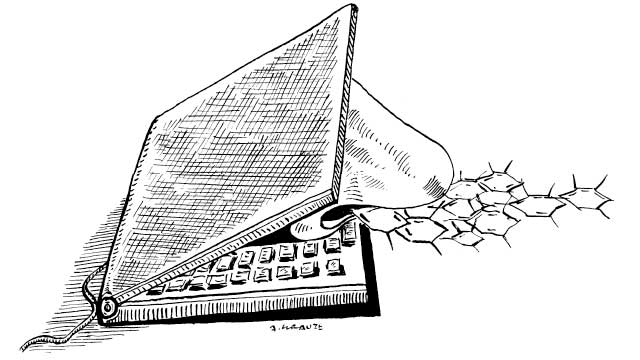

(Image Credit: Andrzej Krauze)

# The Challenge

How do we smell? As with many biological phenomena, the recognition of odor boils down to receptors in our nose (olfactory receptor) recognizing a set of compounds. [Humans use 400 olfactory receptors](https://www.pnas.org/content/116/19/9475) and the interaction between the odor molecule and the olfactory receptor should give rise a sense of smell. 

In a traditional molecular recognition theory, the shape of the molecule and the types of interaction of the molecule to have with receptor plays an important role. The shape has to be complementary to where it binds to the receptor and the molecule should have strong enough interactions with the recpetor to stay in the receptor to be recognized. This concept is well illustrated in this figure from the [wikipedia article](https://en.wikipedia.org/wiki/Docking_(molecular)). 

![Figure](https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Docking_representation_2.png/320px-Docking_representation_2.png)

According to the molecular recognition theory, it should be possible to predict the odor of a molecule by quantifying "features" that give rise certain characteristics of odor. For example, both n-amyl isovalerate and ethyl isovalerate have similar chemical structures and give rise fruity, apple-like scent. 

![n-amyl isovalerate](https://webbook.nist.gov/cgi/cbook.cgi?Struct=C25415627&Type=Color)
![ethyl isovalerate](https://webbook.nist.gov/cgi/cbook.cgi?Struct=C108645&Type=Color)

It is not well understood though, how humans can distinguish so many different smells with only 400 olfactory receptors. In a recent research article investigating the limits of human's sense of smell, the researchers concluded that humans can [sense 1 trillion (10^12) different odors](https://science.sciencemag.org/content/343/6177/1370). 

It is likely that that odorant molecule may binds to multiple olfactory receptor and the sum of those receptor activation could be responsible for our sense of smell rather than one-to-one correspondant relationship between olfactory receptor activation and sense of smell. Despite complex relationship between the molecular features and scent, certain scents are strongly associated with some molecular feature. Therefore, machine learning on chemical feature could successfully identify scent of an test molecule.


# The Data

[RDKit](https://github.com/rdkit/rdkit) is an extremely useful package for handling molecules. Let's install the package and examine the data we have here.

In [ ]:
!wget -q -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -q -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
!time pip install seaborn
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
!gdown --id 1f6b4UtoZEpuUL-PhUTQqxO5wDoiW3Iab
!tar -xvzf learn-to-smell.tar.gz

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
DrawingOptions.bondLineWidth=1.8

# data
import numpy as np
import pandas as pd

# useful
import re, glob, os
from tqdm.notebook import tqdm
from pathlib import Path

In [ ]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
vocabulary = [line.strip() for line in open("data/vocabulary.txt").readlines()]

Let's take a look at what kinds of odors are described in this data set.

In [ ]:
from collections import defaultdict

odor_count = defaultdict(int)
for sentence in df_train.SENTENCE.values:
    for odor in sentence.split(','):
        odor_count[odor] += 1

In [ ]:
sorted_odor = sorted(odor_count, key=lambda x: odor_count[x])[::-1]
print("Top 5 most common odor: ", sorted_odor[:5])
print("Top 5 least common odor: ", sorted_odor[-5:])

Top 5 most common odor:  ['fruity', 'floral', 'woody', 'herbal', 'green']
Top 5 least common odor:  ['overripe', 'ammoniac', 'ambrette', 'fennel', 'blueberry']


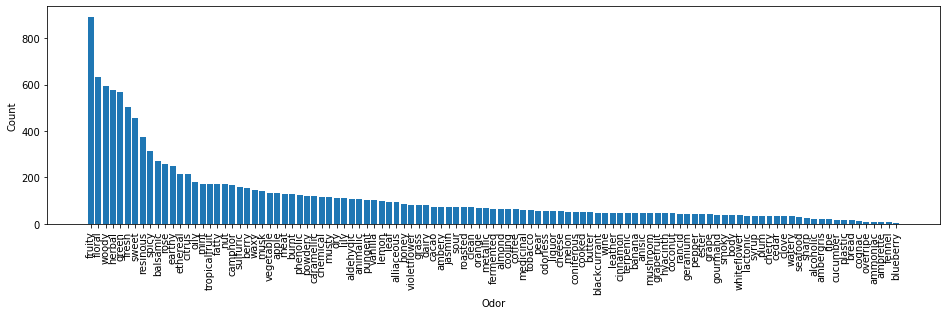

In [ ]:
x_pos = range(len(sorted_odor))
count = [odor_count[k] for k in sorted_odor]
label = sorted_odor

plt.figure(figsize=(16,4))
plt.bar(x_pos, count)
plt.xticks(x_pos, label, rotation=90)
plt.xlabel('Odor')
plt.ylabel('Count')
plt.show()

Looks like odor label is quite imbalanced. Out of 4316 train molecules, over 800 of them have label "fruity". Let's take a look at some of the moleculese have label "fruity". I'll search molecules have most strong odor as "fruity" first.

In [ ]:
mols_fruity = []
for i, row in df_train.iterrows():
    if row.SENTENCE.startswith('fruity'):
        mol = Chem.MolFromSmiles(row.SMILES)
        mol.SetProp('Sentence', row.SENTENCE)
        mols_fruity.append(mol)

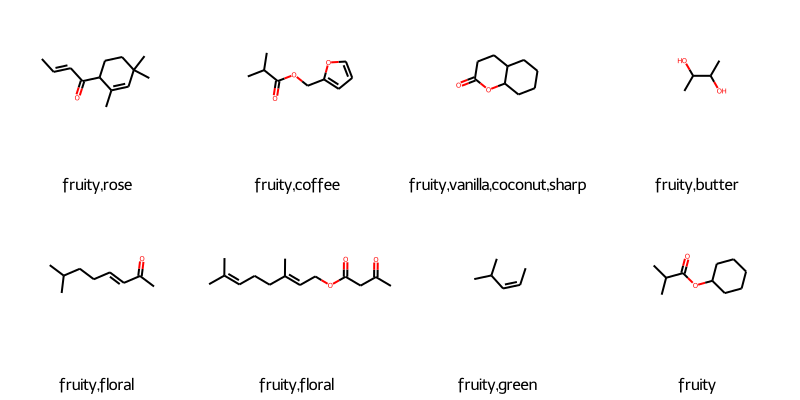

In [ ]:
ms = [Chem.RemoveHs(m) for m in mols_fruity[:8]]
for m in ms: tmp=AllChem.Compute2DCoords(m)
img = Draw.MolsToGridImage(ms,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("Sentence") for x in ms])
img

Looks like there is some similarity between these molecules, particularly the acetate motif (-COO-) appears to be strong indicator for "fruity" odor. However, when I displayed the molecules does not have "fruity" in the most strong odor show some diversity.

In [ ]:
mols_fruity = []
for i, row in df_train.iterrows():
    if 'fruity' in set(row.SENTENCE.split(',')):
        mol = Chem.MolFromSmiles(row.SMILES)
        mol.SetProp('Sentence', row.SENTENCE)
        mols_fruity.append(mol)

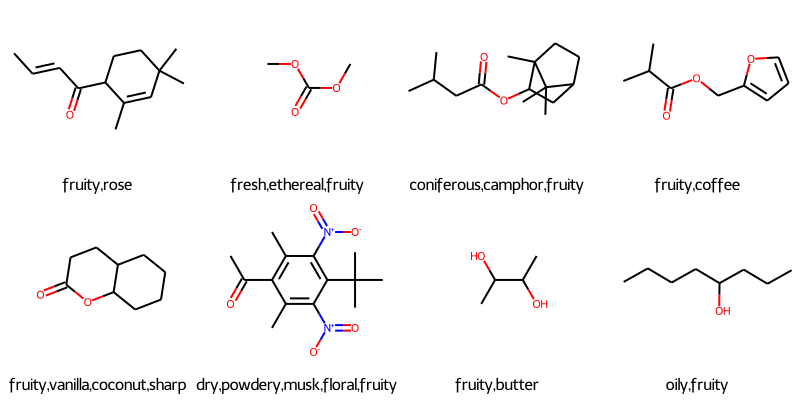

In [ ]:
ms = [Chem.RemoveHs(m) for m in mols_fruity[:8]]
for m in ms: tmp=AllChem.Compute2DCoords(m)
img = Draw.MolsToGridImage(ms,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("Sentence") for x in ms])
img

Alright. Let's look at the odor description and see if there's any association between the labels.

In [ ]:
from itertools import combinations
n_odor = len(vocabulary)
odor_matrix = np.zeros((n_odor, n_odor))
odor_index = {k: i for i, k in enumerate(sorted_odor)}
for sentence in df_train.SENTENCE.values:
    odors = sentence.split(',')
    for o1, o2 in combinations(odors, 2):
        if o1 == o2: continue
        odor_matrix[odor_index[o1], odor_index[o2]] += 1
        odor_matrix[odor_index[o2], odor_index[o1]] += 1

In [ ]:
# get the index of highest count
indices = np.dstack(np.unravel_index(np.argsort(odor_matrix.ravel()), (n_odor, n_odor)))[0][::-1]
print('Top 20 common odor association')
for idx in indices[:40:2]:
    print(f"{sorted_odor[idx[0]]} - {sorted_odor[idx[1]]} : {odor_matrix[idx[0], idx[1]]}")

Top 20 common odor association
fruity - floral : 165.0
fruity - herbal : 162.0
fresh - fruity : 154.0
green - fruity : 150.0
floral - sweet : 136.0
fruity - sweet : 124.0
floral - fresh : 121.0
herbal - fresh : 119.0
green - herbal : 118.0
herbal - floral : 118.0
floral - woody : 111.0
woody - herbal : 103.0
fruity - woody : 97.0
floral - green : 97.0
woody - green : 93.0
resinous - floral : 86.0
resinous - fruity : 80.0
spicy - herbal : 76.0
green - resinous : 75.0
citrus - fresh : 74.0


I feel the odor association is not that strong. For example, the most common odor association is "fruity" and "floral". Given "fruity" label appeared in over 800 times, they are associated in about 20% of the time. If we look at the heatmap, the word "fruity" is indeed associated with a variety of other odors.

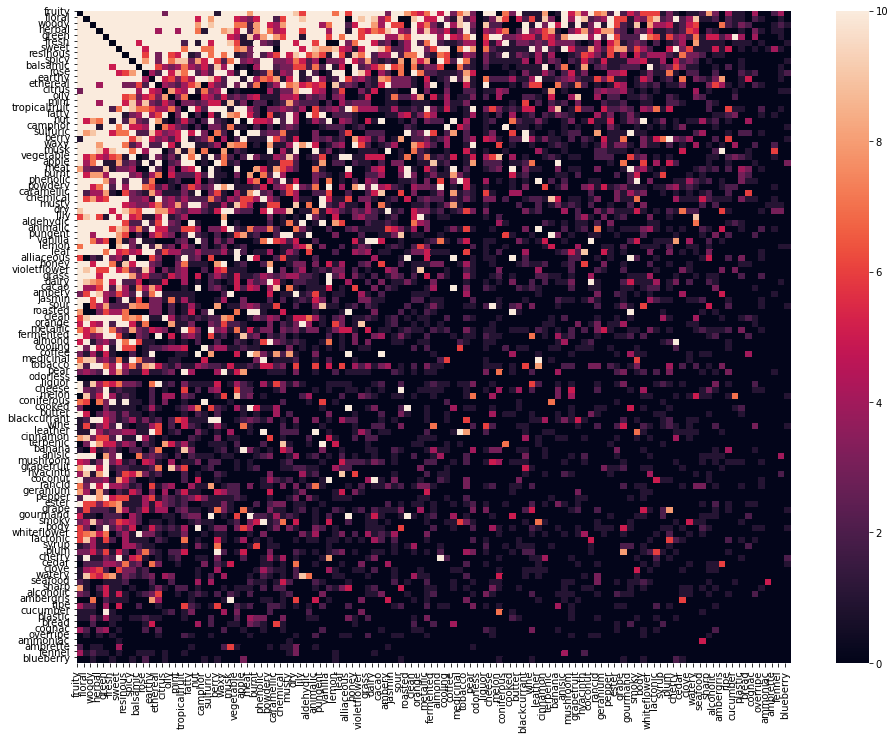

In [ ]:
import seaborn as sns
plt.figure(figsize=(16, 12))
sns.heatmap(odor_matrix, vmax=10)
plt.xticks(range(len(sorted_odor)), sorted_odor)
plt.yticks(range(len(sorted_odor)), sorted_odor)
plt.show()

Heat map of the odor association is nice, but this is hard to pick up high association because of the imbalance in the odor count. How about we compute a association probably by normalizing each row of odor count matrix by the number of times odor appeared in sentences. 

In [ ]:
norm = np.array([odor_count[k] for k in sorted_odor])
odor_matrix_norm = np.copy(odor_matrix)
for i, odor in enumerate(sorted_odor):
    odor_matrix_norm[i] = odor_matrix_norm[i] / odor_count[odor]

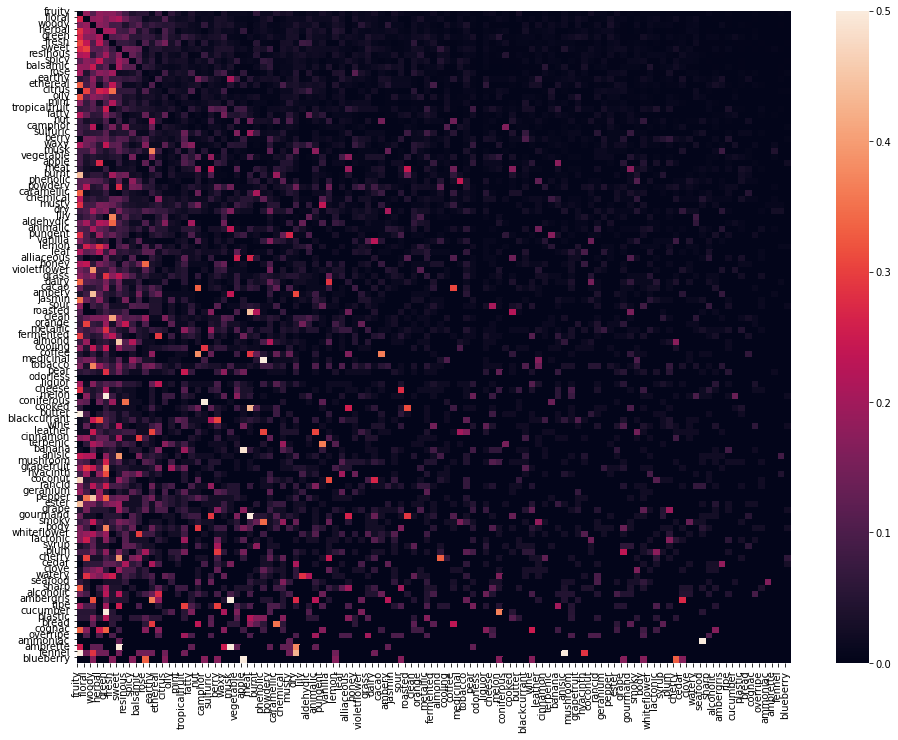

In [ ]:
import seaborn as sns
plt.figure(figsize=(16, 12))
sns.heatmap(odor_matrix_norm, vmax=0.5)
plt.xticks(range(len(sorted_odor)), sorted_odor)
plt.yticks(range(len(sorted_odor)), sorted_odor)
plt.show()

The bright spots in the above heat map represent two odors that appears togehter 50% of the time. For example, whenever the odor "medicinal" appears in the sentence, the word "phenolic" also appeared in 50% of the time. However, such strong association appears to be small. Onward.

In [ ]:
odor1 = 'medicinal'
idx1 = sorted_odor.index(odor1)
idx2 = np.argsort(odor_matrix_norm[idx1])[-1]
assoc_odor = sorted_odor[idx2]
print(f"{odor1} - {assoc_odor}: {odor_matrix_norm[idx1][idx2] * 100}%")

medicinal - phenolic: 50.0%


# Baseline solution

Let's build a baseline solution. RDKit provides a quick and convenient way to featurize molecules, called "fingerprint". A fingerprint of a molecule is a set of hashes for each atom of the molecule. Due to hashing, the same or similar compounds will end up with similar fingerprint whereas it is unlikely that two different molecules have similar fingerprint. 

RDKit supports many different fingerprint algorithms, but we will use Morgan fingerprint. You can learn more about them in [here](https://towardsdatascience.com/a-practical-introduction-to-the-use-of-molecular-fingerprints-in-drug-discovery-7f15021be2b1), [here](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf), and [here](http://www.rdkit.org/docs/GettingStartedInPython.html#explaining-bits-from-morgan-fingerprints).

In [ ]:
from sklearn.model_selection import train_test_split

# generate molecules and featurize
mols = [Chem.MolFromSmiles(sm) for sm in df_train.SMILES]
features = [AllChem.GetMorganFingerprint(m, 2, useChirality=True) for m in mols]

X = features
y = df_train.SENTENCE
indices = np.arange(len(X))

# split into train/test set
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)

Morgan fingerprint for each molecule is computed and the 5 most close entries from the training data is selected using fingerprint similarity. Let's predict the sentences for our test data and check the score.

In [ ]:
y_pred = []
for fp in X_test:
    # pick 5 most close molecule in terms of fingerprint
    indices = np.argsort(DataStructs.BulkDiceSimilarity(fp, X_train))[-5:]
    pred = []
    for idx in indices:
        orders = y_train.tolist()[idx]
        pred.append(orders)
    y_pred.append(";".join(pred))

In [ ]:
def score(x, y):
    truth = set(x.split(',')[:3])
    preds = [set(token.split(',')[:3]) for token in y.split(';')]
    best_score = 0
    for pred in preds:
        n_overlap = len(pred.intersection(truth))
        score = n_overlap / (len(truth) + len(pred) - n_overlap)
        if score > best_score:
            best_score = score
    return best_score

In [ ]:
scores = [score(sentence, y_pred[i]) for i, sentence in enumerate(y_test.tolist())]
print(np.mean(scores))

0.3732445987654321


In our simple test, where we predict odor sentence using 5 most similar entries from the database scores 0.37. Let's check the test cases failed badly.

In [ ]:
def display_worst_prediction(index):
    """Display prediction sorted based on scores.
    
    Returns the image composed of test molecule with the true label and the five
    nearst neighbors and their label. The predicted label is simply the concatenated
    labels of the neighbors.
    """
    
    worst_case_indices = np.argsort(scores)
    idx = worst_case_indices[index]
    worst_case_mol = mols[indices_test[idx]]
    worst_case_label = y_test.values[idx]
    worst_case_fp = X_test[idx]
    worst_case_neighbors_idx = np.argsort(DataStructs.BulkDiceSimilarity(worst_case_fp, X_train))[-5:]
    worst_case_neighbors_mols = [mols[indices_train[idx]] for idx in worst_case_neighbors_idx]

    ms = [Chem.RemoveHs(m) for m in [worst_case_mol] + worst_case_neighbors_mols]
    legends = [y_train.values[idx] for idx in worst_case_neighbors_idx]
    for m in ms: tmp=AllChem.Compute2DCoords(m)
    img = Draw.MolsToGridImage(ms,molsPerRow=6,subImgSize=(200,200),legends=[worst_case_label] + legends)
    return img

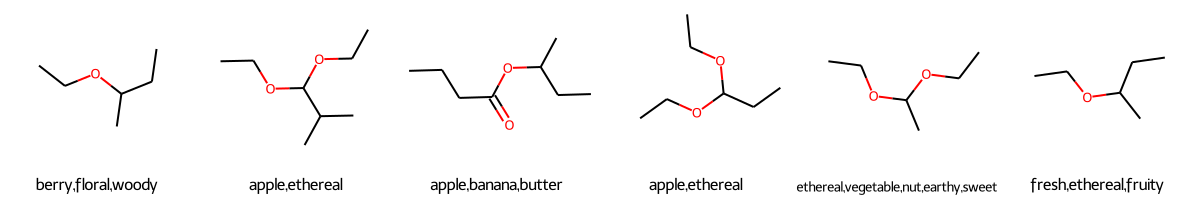

In [ ]:
display_worst_prediction(0)

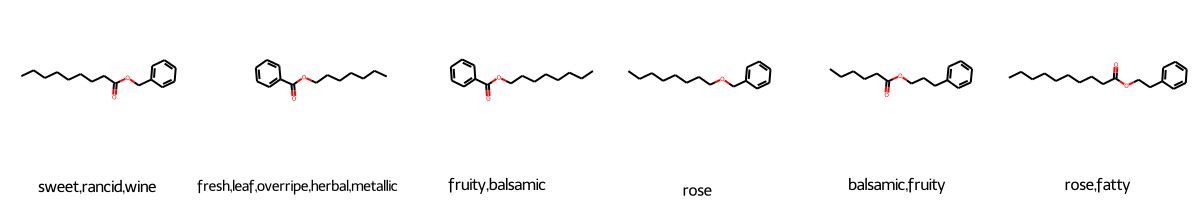

In [ ]:
display_worst_prediction(1)

Although the molecules look very similar each other, the test molecule scores poorly have very different odor description from the training set. One thing to keep in mind is that the drawing ignores the stereochemistry. So, it is possible that these molecules have different stereochemistry. 

Looking at the worst prediction case, it is easy to see some predictions are duplicated ("apple,ethereal" apperaed twice). Some easy tweak can be made for those entries.

Let's build the prediction with all the training data.

# Prediction

In [ ]:
df_test = pd.read_csv('data/test.csv')
mols_test = [Chem.MolFromSmiles(sm) for sm in df_test.SMILES]
features_test = [AllChem.GetMorganFingerprint(m, 2, useChirality=True) for m in mols_test]

X_train = X
y_train = y

In [ ]:
y_pred = []
for fp in features_test:
    indices = np.argsort(DataStructs.BulkDiceSimilarity(fp, X_train))[-5:]
    pred = []
    for idx in indices:
        orders = y_train.tolist()[idx]
        pred.append(orders)
    y_pred.append(";".join(pred))

In [ ]:
df_test['PREDICTIONS'] = y_pred

In [ ]:
df_test.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This submission scores 0.395 in Top-5 TSS and 0.215 in Top-2 TSS score. 